In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Add, Input
from keras.models import Model

In [2]:
# Define residual block
def residual_block(x, filters, strides=1):
    identity = x

    x = Conv2D(filters, kernel_size=(3, 3), padding='same', strides=strides, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    if strides != 1 or identity.shape[-1] != filters:
        identity = Conv2D(filters, kernel_size=(1, 1), padding='same', strides=strides)(identity)
    
    x = Add()([x, identity])
    x = tf.nn.relu(x)
    return x

In [4]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    directory='plant disease/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

validation_ds = keras.preprocessing.image_dataset_from_directory(
    directory='plant disease/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

Found 9281 files belonging to 5 classes.
Found 2319 files belonging to 5 classes.


In [5]:
def process(image, label):
    image = tf.cast(image / 255., tf.float32)
    return image, label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [6]:
# Create ResNet model
input_shape = (256, 256, 3)
inputs = Input(shape=input_shape)

x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = residual_block(x, filters=64)
x = residual_block(x, filters=64)
x = residual_block(x, filters=64)

x = residual_block(x, filters=128, strides=2)
x = residual_block(x, filters=128)
x = residual_block(x, filters=128)

x = residual_block(x, filters=256, strides=2)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)

x = residual_block(x, filters=512, strides=2)
x = residual_block(x, filters=512)
x = residual_block(x, filters=512)

x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_10 (BatchN  (None, 32, 32, 128)  512        ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_4 (Add)                    (None, 32, 32, 128)  0           ['batch_normalization_10[0][0]', 
                                                                  'tf.nn.relu_3[0][0]']           
                                                                                                  
 tf.nn.relu_4 (TFOpLambda)      (None, 32, 32, 128)  0           ['add_4[0][0]']                  
                                                                                                  
 conv2d_12 (Conv2D)             (None, 32, 32, 128)  147584      ['tf.nn.relu_4[0][0]']           
                                                                                                  
 batch_nor

                                                                  'conv2d_23[0][0]']              
                                                                                                  
 tf.nn.relu_9 (TFOpLambda)      (None, 8, 8, 512)    0           ['add_9[0][0]']                  
                                                                                                  
 conv2d_24 (Conv2D)             (None, 8, 8, 512)    2359808     ['tf.nn.relu_9[0][0]']           
                                                                                                  
 batch_normalization_21 (BatchN  (None, 8, 8, 512)   2048        ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_25 (Conv2D)             (None, 8, 8, 512)    2359808     ['batch_normalization_21[0][0]'] 
          

94765736/94765736 [==============================] - 293s 3us/step
Epoch 1/5
291/291 [==============================] - 877s 3s/step - loss: -19614.6562 - accuracy: 0.2069 - val_loss: -84715.1875 - val_accuracy: 0.2070
Epoch 2/5
291/291 [==============================] - 985s 3s/step - loss: -333052.4062 - accuracy: 0.2069 - val_loss: -727720.4375 - val_accuracy: 0.2070
Epoch 3/5
291/291 [==============================] - 569s 2s/step - loss: -1469340.0000 - accuracy: 0.2069 - val_loss: -2437413.5000 - val_accuracy: 0.2070
Epoch 4/5
291/291 [==============================] - 511s 2s/step - loss: -3845011.0000 - accuracy: 0.2069 - val_loss: -5551316.5000 - val_accuracy: 0.2070
Epoch 5/5
291/291 [==============================] - 511s 2s/step - loss: -7778333.5000 - accuracy: 0.2069 - val_loss: -10325135.0000 - val_accuracy: 0.2070


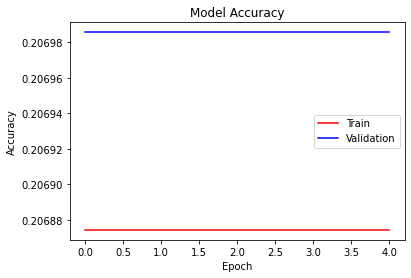

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
model = keras.Sequential()
model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, epochs=5, validation_data=validation_ds)

# Plot accuracy
plt.plot(history.history['accuracy'], color='red', label='Train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()